<a href="https://colab.research.google.com/github/commetra/project-1/blob/main/sp5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -q https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
!unzip -q dsplus_integrated_project_4.zip

replace to_upload/test_images.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


##Библиотеки

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import torch
import torchvision.transforms as transforms
import tensorflow as tf
import re

from torchvision import models
from PIL import Image

from keras.preprocessing import image
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor



from sklearn.preprocessing import StandardScaler



DATA_PATH = '/content/to_upload/'

##Загрузка

В файле **train_dataset.csv** собрана информация, необходимая для обучения:
- имя файла изображения,
- идентификатор описания и текст описания, для одной картинки может быть доступно до 5 описаний.
- идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

In [3]:
train_dataset = pd.read_csv(DATA_PATH +'train_dataset.csv')
train_dataset.head(2)

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [4]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [5]:
train_dataset.duplicated().sum()

0

Пропусков нет.

В файле **ExpertAnnotations.tsv** содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов.

Колоноки:
- image - Имя файла изображения.
- query_id - Идентификатор описания.
- exp_1, exp_2, exp_3 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4:
- 1 — изображение и запрос совершенно не соответствуют друг другу,
- 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует,
- 3 — запрос и текст соответствуют с точностью до некоторых деталей,
- 4 — запрос и текст соответствуют полностью.

In [6]:
expert_annotations = pd.read_csv(DATA_PATH + 'ExpertAnnotations.tsv', sep='\t', header=None)
expert_annotations.columns = ['image', 'query_id', 'exp_1', 'exp_2', 'exp_3']
expert_annotations.head(2)

,image,query_id,exp_1,exp_2,exp_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2


In [7]:
expert_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   exp_1     5822 non-null   int64 
 3   exp_2     5822 non-null   int64 
 4   exp_3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


В файле **CrowdAnnotations.tsv** — данные по соответствию изображения и описания, полученные с помощью краудсорсинга.

Колоноки:
- image - имя файла изображения;
- query_id - идентификатор описания;
- conf_rate - доля людей, подтвердивших, что описание соответствует изображению;
- confirm - количество человек, подтвердивших, что описание соответствует изображению;
- not_confirm - количество человек, подтвердивших, что описание не соответствует изображению.

In [8]:
crowd_annotations = pd.read_csv(DATA_PATH + 'CrowdAnnotations.tsv', sep='\t', header=None)
crowd_annotations.columns = ['image', 'query_id', 'conf_rate', 'confirm', 'not_confirm']
crowd_annotations.head(2)

,image,query_id,conf_rate,confirm,not_confirm
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3


In [9]:
crowd_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        47830 non-null  object 
 1   query_id     47830 non-null  object 
 2   conf_rate    47830 non-null  float64
 3   confirm      47830 non-null  int64  
 4   not_confirm  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


Пропусков нет.

В файле **test_queries.csv** находится информация, необходимая для тестирования:
- идентификатор запроса, текст запроса и релевантное изображение;
- для одной картинки может быть доступно до 5 описаний;
- идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

In [10]:
test_queries = pd.read_csv(DATA_PATH + 'test_queries.csv', sep='|', index_col=[0])
test_queries.head(2)

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg


In [11]:
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


Пропусков нет.

В папке **test_images** содержатся изображения для тестирования модели.

In [12]:
test_images = pd.read_csv(DATA_PATH + 'test_images.csv')
test_images.head(2)

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg


In [13]:
test_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


##Исследовательский анализ данных

###Анализ экспертных и краудсорсинговых оценок

####Анализ экспертных оценок

Поскольку у нас есть несколько экспертов, их оценки могут варьироваться. Используя медиану, можно получить более надежное представление о том, какова "центральная" оценка в этой группе экспертов. Это полезно, так как есть вероятность разногласий между экспертами.

In [14]:
expert_annotations.shape

(5822, 5)

Всего 5822 экспертных оценок.

In [15]:
# Вычисление медианы
expert_annotations['exp_median'] = (expert_annotations[['exp_1', 'exp_2', 'exp_3']]).median(axis=1)

Приведем полученные значение центральной оценки к диапазону от 0 до 1.

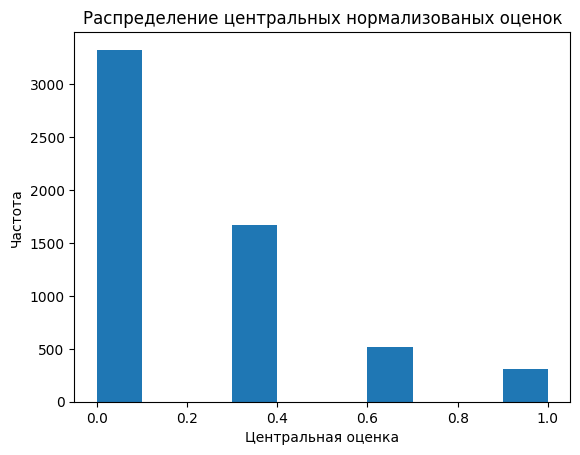

In [16]:
expert_annotations['exp_norm'] = (expert_annotations['exp_median'] - expert_annotations['exp_median'].min()) / (expert_annotations['exp_median'].max() - expert_annotations['exp_median'].min())

# Гистограмма
expert_annotations['exp_norm'].plot.hist()
plt.title('Распределение центральных нормализованых оценок')
plt.xlabel('Центральная оценка')
plt.ylabel('Частота')
plt.show();

Центральная оценка у большенства экспертов склоняется к тому, что текст соответствует картинке.


In [17]:
expert_annotations.describe()

,exp_1,exp_2,exp_3,exp_median,exp_norm
count,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000
mean,1.436620,1.624356,1.881999,1.624356,0.208119
std,0.787084,0.856222,0.904087,0.856222,0.285407
min,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,0.000000
50%,1.000000,1.000000,2.000000,1.000000,0.000000
75%,2.000000,2.000000,2.000000,2.000000,0.333333
max,4.000000,4.000000,4.000000,4.000000,1.000000


#### Анализ краудсорсинговых оценок

In [18]:
crowd_annotations.shape

(47830, 5)

Всего 47830 краудсорсинговых оценок.

In [19]:
crowd_annotations.describe()

,conf_rate,confirm,not_confirm
count,47830.000000,47830.000000,47830.000000
mean,0.068786,0.208488,2.820155
std,0.207532,0.628898,0.656676
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000
50%,0.000000,0.000000,3.000000
75%,0.000000,0.000000,3.000000
max,1.000000,5.000000,6.000000


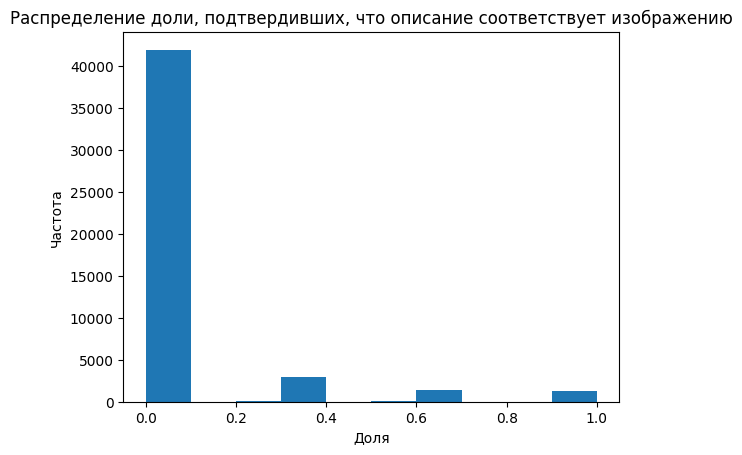

In [20]:
# Гистограмма
crowd_annotations['conf_rate'].plot.hist()
plt.title('Распределение доли, подтвердивших, что описание соответствует изображению')
plt.xlabel('Доля')
plt.ylabel('Частота')
plt.show();

Распределение доли людей, подтвердивших, что описание соответствует изображению (conf_rate) показвает что большенство не потвердило соотвествие. Такой дисбаланс оценок окажет негативное влияние на обучение модели.

Вывод: для дальнейшей работы над созданием модели лучше использовать датасет с экспертными оценками.

Объеденим экспертные оценки и тренировочный датафреймы.

In [21]:
train_data = train_dataset\
.merge(expert_annotations[['image', 'query_id', 'exp_norm']], how='left', on=['image', 'query_id'])
train_data.head(2)

,image,query_id,query_text,exp_norm
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0


In [22]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5822 non-null   object 
 1   query_id    5822 non-null   object 
 2   query_text  5822 non-null   object 
 3   exp_norm    5822 non-null   float64
dtypes: float64(1), object(3)
memory usage: 182.1+ KB


Пропусков нет.

In [23]:
train_data.duplicated().sum()

0

Дублиатов нет.

##Проверка данных

Удалим все изображения, которые нарушают закон из обучающей выборки.

In [24]:
# Список запрещённых слов для проверки
ban_wordlist = ['girl', 'girls', 'boy', 'boys', 'child', 'children',
                'baby', 'babies', 'young', 'teen', 'teenager', 'kid',
                'kids', 'toddler', 'toddlers', 'minor', 'youth',
                'junior', 'infant', 'infants'
                ]

In [25]:
# Функция проверки запрещённых слов
def delete_ban_words(string, ban_wordlist):
    # Разделение строки
    lst = string.split()  # Если string не строка, это может вызвать ошибку

    # Проверка на наличие запрещённых слов:
    if set(lst).intersection(ban_wordlist):
        return np.nan # если такие слова есть
    else:
        return string # саму строку, если запрещённых слов нет


In [26]:
# Функция проверки содержит ли входная строка хотя бы одно из запрещённых слов
def find_ban_text(string, ban_wordlist):
    # Проверка наличия запрещённых слов
    if any(word in ban_wordlist for word in string.split()):
        return string
    else:
        return np.nan

Найдём все комментарии (или строки) из колонки 'query_text' train_dataset, которые содержат одно или несколько запрещённых слов из списка ban_wordlist

In [27]:
ban_comments = train_data['query_text'].apply(lambda x: find_ban_text(x, ban_wordlist)).dropna()
ban_comments

,query_text
0,A young child is wearing blue goggles and sitt...
1,A young child is wearing blue goggles and sitt...
2,A young child is wearing blue goggles and sitt...
3,A young child is wearing blue goggles and sitt...
4,A young child is wearing blue goggles and sitt...
...,...
5802,A girl wearing a swimsuit top wears a sign to ...
5803,A young girl balances on wooden pylons at the ...
5804,A young girl balances on wooden pylons at the ...
5814,a woman holding a small ball chasing after a s...


Найдено 1564 строки с запрещёнными словами.

In [28]:
# Оставим только строки с запрещенными комментариями
train_data_ban = train_data[train_data['query_text'].isin(ban_comments)]

# Убираем последние 2 символа из query_id
train_data_ban['query_id'] = train_data_ban['query_id'].map(lambda x: str(x)[:-2])

# Cписок запрещенных картинок, которые нужно удалить
ban_images = train_data_ban['query_id'].unique()

# Убираем из датафрейма все запрещенные изображения
train_data_clear = train_data[train_data['image'].isin(ban_images) == False]

train_data_clear.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4091 entries, 0 to 5820
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       4091 non-null   object 
 1   query_id    4091 non-null   object 
 2   query_text  4091 non-null   object 
 3   exp_norm    4091 non-null   float64
dtypes: float64(1), object(3)
memory usage: 159.8+ KB


<ipython-input-28-bdef13d3c16f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_ban['query_id'] = train_data_ban['query_id'].map(lambda x: str(x)[:-2])


##Векторизация изображений

Векторизация изображений с помощью Keras и предобученной модели ResNet50.

In [29]:
# Загружаем предобученную модель ResNet50 без верхнего классификационного слоя
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def vectorize_image(image_path):
    # Загружаем изображение и изменяем его размер
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)  # Преобразуем в массив
    img_array = np.expand_dims(img_array, axis=0)  # Добавляем размерность

    # Предобрабатываем изображение
    img_array = preprocess_input(img_array)

    # Получаем вектор признаков
    features = model.predict(img_array)
    return features.flatten()  # Преобразуем вектор в одномерный массив

# Путь к папке с изображениями
image_folder = '/content/to_upload/train_images'

# Список для хранения векторов признаков
image_vectors = []
image_names = []

# Проходим по всем файлам в папке
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    try:
        vector = vectorize_image(image_path)
        image_vectors.append(vector)
        image_names.append(image_name)  # Сохраняем имя изображения
    except Exception as e:
        print(f"Error processing {image_name}: {e}")

# Создаем DataFrame для хранения векторов и имен
df_image_vectors = pd.DataFrame(image_vectors)
df_image_vectors['image'] = image_names

# Проверка результатов
df_image_vectors.head(2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,image
0,1.416358,0.360958,0.272582,0.000000,0.078336,0.482590,0.412531,0.328610,0.233321,0.696362,...,1.006416,1.376078,0.709524,0.559089,0.213991,0.000000,0.815377,0.292692,0.174643,2884301336_dc8e974431.jpg
1,0.060772,0.729254,0.512303,2.580915,0.054876,2.107044,0.425228,0.002946,1.281548,0.158119,...,0.285615,0.967672,0.015468,1.263540,0.026753,2.939803,0.194562,0.099030,0.894081,1417031097_ab656bc4bd.jpg


In [30]:
df_image_vectors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 2049 entries, 0 to image
dtypes: float32(2048), object(1)
memory usage: 7.8+ MB


В результате векторизации каждое изображение из папки train_images превращается в одномерный вектор размером 2048.

##Векторизация текста

In [31]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
# Создаем экземпляр лемматизатора
wnl = WordNetLemmatizer()

# Функция для преобразования тегов
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN': 'n', 'NNS': 'n', 'JJ': 'a', 'VB': 'v',
                  'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v',
                  'VBZ': 'v', 'RB': 'r'}
    return morphy_tag.get(penntag, 'n')  # Возвращаем 'n' по умолчанию

# Функция для лемматизации текстов
def lemmatize_sent(text):
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
            for word, tag in pos_tag(word_tokenize(text))]

# Проверяем результат лемматизации
sentence = "The striped bats are hanging on their feet for best"
lemmatized_sentence = ' '.join(lemmatize_sent(sentence))

print("Лемматизированное предложение:", lemmatized_sentence)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Лемматизированное предложение: the striped bat be hang on their foot for best


In [32]:
# Применяем лемматизацию к столбцу 'query_text'
train_data_clear['lemmatized_text'] = train_data_clear['query_text'].apply(lambda x: ' '.join(lemmatize_sent(x)))

# Печатаем результаты
train_data_clear.head(2)

<ipython-input-32-37910c8e63f3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_clear['lemmatized_text'] = train_data_clear['query_text'].apply(lambda x: ' '.join(lemmatize_sent(x)))


,image,query_id,query_text,exp_norm,lemmatized_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0,a young child be wear blue goggles and sit in ...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0,a young child be wear blue goggles and sit in ...


In [33]:
# Инициализация TF-IDF векторизатора
tfidf_vectorizer = TfidfVectorizer()

# Применение векторизации к описаниям
tfidf_matrix = tfidf_vectorizer.fit_transform(train_data_clear['lemmatized_text'])

# Преобразуем в DataFrame для удобства
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['image'] = train_data_clear['image']
tfidf_df['exp_norm'] = train_data_clear['exp_norm']

# Просмотр результатов
tfidf_df


,12,28,58,about,above,across,action,actor,adult,aerial,...,wrinkled,write,yard,yellow,yerba,you,young,youth,image,exp_norm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.26093,0.0,1056338697_4f7d7ce270.jpg,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.26093,0.0,1262583859_653f1469a9.jpg,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.26093,0.0,NaN,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.26093,0.0,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.26093,0.0,2621415349_ef1a7e73be.jpg,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.414788,0.0,0.00000,0.0,2999730677_0cfa1c146e.jpg,0.333333
4087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,326456451_effadbbe49.jpg,0.333333
4088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,3270691950_88583c3524.jpg,0.000000
4089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,3642220260_3aa8a52670.jpg,0.333333


In [34]:
# Удаляем строки, где значение в столбце 'image' равно NaN
tfidf_cleaned = tfidf_df.dropna(subset=['image'])

In [35]:
tfidf_cleaned

,12,28,58,about,above,across,action,actor,adult,aerial,...,wrinkled,write,yard,yellow,yerba,you,young,youth,image,exp_norm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.26093,0.0,1056338697_4f7d7ce270.jpg,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.26093,0.0,1262583859_653f1469a9.jpg,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.26093,0.0,2621415349_ef1a7e73be.jpg,0.000000
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.26093,0.0,3155451946_c0862c70cb.jpg,0.000000
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.26093,0.0,3222041930_f642f49d28.jpg,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.414788,0.0,0.00000,0.0,2999730677_0cfa1c146e.jpg,0.333333
4087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,326456451_effadbbe49.jpg,0.333333
4088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,3270691950_88583c3524.jpg,0.000000
4089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,3642220260_3aa8a52670.jpg,0.333333


Размер вектора 1245. Осталось 2900 строк.

Объединение векторов.

In [36]:
# Объединяем два DataFrame по столбцу image
train_vectors = pd.merge(df_image_vectors, tfidf_cleaned, on='image', how='left')
train_vectors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3195 entries, 0 to 3194
Columns: 3294 entries, 0 to exp_norm
dtypes: float32(2048), float64(1245), object(1)
memory usage: 55.3+ MB


In [37]:
train_vectors.head(2)

,0,1,2,3,4,5,6,7,8,9,...,wring,wrinkled,write,yard,yellow,yerba,you,young,youth,exp_norm
0,1.416358,0.360958,0.272582,0.0,0.078336,0.48259,0.412531,0.32861,0.233321,0.696362,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1.416358,0.360958,0.272582,0.0,0.078336,0.48259,0.412531,0.32861,0.233321,0.696362,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333


In [38]:
# Удаление строк с хотя бы одним NaN
train_vectors = train_vectors.dropna()

# Сброс индексов
train_vectors.reset_index(drop=True, inplace=True)

nan_per_row = train_vectors.isna().sum()
nan_per_row

,0
0,0
1,0
2,0
3,0
4,0
...,...
yerba,0
you,0
young,0
youth,0


##Описание получившихся пар векторов.

**Вектор текстового описания**.

Размерность - T = 1245.
Этот вектор содержит признаки, извлеченные из текстового описания. Признаки могут отражать, например, частоту слов, семантические отношения или контексты слова, в зависимости от используемой векторизации.

**Вектор изображения**.

Размерность - I = 2048.
Этот вектор содержит признаки, извлеченные из изображения. Признаки могут представлять высокоуровневые характеристики изображения, такие как текстуры, формы и объекты, в зависимости от свёрточной нейронной сети, использованной для извлечения признаков.

**Конкатенированный вектор**.

Размерность - T+I = 3293.
Этот вектор объединяет информацию из текстового и визуального представления и может использоваться для дальнейшего обучения или анализа, для предсказания оценок экспертов.

Конкатенированный вектор можно использовать в качестве входа для модели, будь то линейная регрессия или полносвязная нейронная сеть. Размерность входных данных для модели будет равна размерности конкатенированного вектора.

Примеры применения:
- Классификация. Если у вас есть текстовое описание и изображение, конкатенированный вектор может помочь модели понять контекст и содержание в совокупности.
- Поиск. Конкатенированные векторы могут использоваться для поиска похожих изображений по текстовому запросу и наоборот.

**Заключение.**
Объемные пары векторов (векторы текстов и изображений) дают возможность модели обрабатывать более сложные данные, учитывая как текстовые, так и визуальные аспекты. Конкатенация векторов расширяет пространство признаков и может привести к лучшим результатам в задачах, требующих совокупного анализа данных.

##Модели для предсказания близости двух векторов

Разделим датафрейм на тренировочную и тестовую выборки с использованием GroupShuffleSplit. Этот подход позволяет гарантировать, что одно и то же изображение попадет либо в обучающую, либо в тестовую выборку, а не в обе. Это помогает избежать утечки данных, что особенно критично в задачах машинного обучения, связанных с изображениями и текстами.

In [39]:
# Использование GroupShuffleSplit для разбиения на тренировочную и тестовую выборки
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)

# Запуск разбиения
train_indices, test_indices = next(gss.split(X=train_vectors.drop(columns=['exp_norm']),
                                             y=train_vectors['exp_norm'],
                                             groups=train_vectors['image']))

# Создание тренировочных и тестовых DataFrame
train_df = train_vectors.loc[train_indices].reset_index(drop=True)
test_df = train_vectors.loc[test_indices].reset_index(drop=True)

# Удаление ненужных столбцов из train_df и test_df
train_df = train_df.drop(columns=['image'])
test_df = test_df.drop(columns=['image'])

# Извлечение целевых переменных
y_train = train_df['exp_norm']
y_test = test_df['exp_norm']

# Проверка размеров
print(f'Train DataFrame shape: {train_df.shape}')
print(f'Test DataFrame shape: {test_df.shape}')
print(f'Training targets shape: {y_train.shape}')
print(f'Test targets shape: {y_test.shape}')

Train DataFrame shape: (2008, 3293)
Test DataFrame shape: (892, 3293)
Training targets shape: (2008,)
Test targets shape: (892,)


Для сравнения точности различных моделей в задаче регрессии, такой как предсказание оценок экспертов по изображениям и текстовым описаниям, подходящей метрикой будет средняя абсолютная ошибка (MAE - Mean Absolute Error) или среднеквадратичная ошибка (MSE - Mean Squared Error). Эти метрики хорошо работают для задач регрессии и позволяют понять, насколько предсказания модели близки к реальным значениям.

Масштабирование признаков.

In [40]:
# Преобразование всех имен столбцов к строкам
train_df.columns = train_df.columns.astype(str)
test_df.columns = test_df.columns.astype(str)

In [41]:
# Создаем экземпляр StandardScaler
scaler = StandardScaler()

# Масштабирование признаков в тренировочных данных
train_df_scaled = scaler.fit_transform(train_df)

# Масштабирование признаков в тестовых данных
test_df_scaled = scaler.transform(test_df)

# Если хотите, вы можете превратить обратно в DataFrame
train_df_scaled = pd.DataFrame(train_df_scaled, columns=train_df.columns)
test_df_scaled = pd.DataFrame(test_df_scaled, columns=test_df.columns)

###Linear Regression

In [42]:
# Обучение линейной регрессии
linear_model = LinearRegression()
linear_model.fit(train_df_scaled, y_train)

# Предсказания и оценка
y_pred_linear = linear_model.predict(test_df_scaled)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
print(f'MAE для Linear Regression: {mae_linear}')

MAE для Linear Regression: 0.027271862246512638


###Decision Tree Regressor

In [43]:
# Определение модели
dtr_model = DecisionTreeRegressor(random_state=29)

# Определение гиперпараметров
hyperparams = {'max_depth': [50, 100],
              'min_samples_leaf': [5, 10, 15, 20, 50, 100, 200]
}

# Создание и запуск поиска по сетке (Grid Search)
grid_search = GridSearchCV(dtr_model, hyperparams, scoring='neg_mean_absolute_error',cv=5)
grid_search.fit(train_df_scaled, y_train)

dtr_best_model = grid_search.best_estimator_
dtr_mae = -grid_search.best_score_

# Выводим лучшие параметры и лучший MAE
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший MAE: {dtr_mae}")

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Лучшие параметры: {'max_depth': 50, 'min_samples_leaf': 50}
Лучший MAE: 1.560130502308145e-16


###Полносвязная нейронная сеть

In [44]:
# Создание модели нейронной сети
def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

# Обучение модели
nn_model = create_nn_model(train_df_scaled.shape[1])
nn_model.fit(train_df_scaled, y_train, epochs=50, batch_size=32, verbose=1)

# Предсказания и оценка
y_pred_nn = nn_model.predict(test_df_scaled)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
print(f'MAE for Neural Network: {mae_nn}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2670
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1949
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1795
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1544
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1522
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1429
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1346
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1204
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1067
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0997
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0913
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0877
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0822
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0730
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0708
Epoch 16/50
63/63

- MAE для Linear Regression: 0.027. Линейная регрессия продемонстрировала низкую среднюю абсолютную ошибку, что говорит о том, что предсказания этой модели в среднем отклоняются от фактических значений на 2.73%. Это указывает на хорошую производительность модели, которая эффективно учитывает линейные зависимости между входными признаками и целевой переменной.
- MAE для DecisionTreeRegressor: 1.560130502308145e-16. Значение MAE, близкое к нулю, указывает на то, что модель Decision Tree Regressor практически не ошибается, что может быть связано с тем, что она точно запоминает тренды на обучающем наборе данных. Однако такое малое значение MAE также может сигнализировать о переобучении модели, особенно если модель была высоко настроена на тренировочные данные.
- MAE для Neural Network: 0.176. Нейронная сеть показала более высокое значение MAE, чем линейная регрессия, на уровне 0.176, что указывает на то, что предсказания нейронной сети имеют более значительные отклонения от истинных значений. Это может говорить о необходимости улучшения архитектуры сети, настройки гиперпараметров или увеличения объема данных для обучения, чтобы повысить способность модели обобщать.

##Тестирование и демонстрация модели

In [45]:
# Путь к папке с изображениями
test_image_folder = '/content/to_upload/test_images'

# Список для хранения векторов признаков
test_image_vectors = []
test_image_names = []

# Проходим по всем файлам в папке
for test_image_name in os.listdir(test_image_folder):
    test_image_path = os.path.join(test_image_folder, test_image_name)
    try:
        test_vector = vectorize_image(test_image_path)
        test_image_vectors.append(test_vector)
        test_image_names.append(test_image_name)  # Сохраняем имя изображения
    except Exception as e:
        print(f"Error processing {test_image_name}: {e}")

# Создаем DataFrame для хранения векторов и имен
test_df_image_vectors = pd.DataFrame(test_image_vectors)
test_df_image_vectors['image'] = test_image_names

# Проверка результатов
test_df_image_vectors.head(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,image
0,1.498005,0.228910,0.235909,0.194951,0.27011,0.000000,0.000000,0.210029,0.004757,1.408493,...,0.016813,0.244848,1.939879,0.380886,0.198964,0.113101,0.250504,0.258705,0.007251,2431120202_b24fe2333a.jpg
1,0.129202,0.441974,0.028948,2.680498,0.78425,0.111432,0.083201,0.772765,0.283325,0.537347,...,0.425817,0.312966,0.984435,0.050045,0.254676,0.152854,0.413795,0.346667,1.508629,3653484549_f316590b0f.jpg


In [46]:
# Применяем лемматизацию к столбцу 'query_text'
test_queries['lemmatized_text'] = test_queries['query_text'].apply(lambda x: ' '.join(lemmatize_sent(x)))

# Печатаем результаты
test_queries.sample(10)

,query_id,query_text,image,lemmatized_text
41,186346360_541047336f.jpg#1,A girl in a bikini top stands in front of a be...,186346360_541047336f.jpg,a girl in a bikini top stand in front of a bea...
93,2399219552_bbba0a9a59.jpg#3,little boy playing basketball in the grass,2399219552_bbba0a9a59.jpg,little boy play basketball in the grass
226,3091962081_194f2f3bd4.jpg#1,A man with glasses wearing all black sits on g...,3091962081_194f2f3bd4.jpg,a man with glass wear all black sits on grass ...
462,661749711_6f408dad62.jpg#2,A Yorkie trying to catch a red toy .,661749711_6f408dad62.jpg,a yorkie try to catch a red toy .
306,3386953179_84c2d7922f.jpg#1,A snowboarder in a red jacket slides down a sn...,3386953179_84c2d7922f.jpg,a snowboarder in a red jacket slide down a sno...
135,2552438538_285a05b86c.jpg#0,The three children are standing on and by a fe...,2552438538_285a05b86c.jpg,the three child be stand on and by a fence .
186,2977379863_2e8d7a104e.jpg#1,A girl in a black cape with a group of other c...,2977379863_2e8d7a104e.jpg,a girl in a black cape with a group of other c...
286,3287969199_08e775d896.jpg#1,A blue bird flying over water .,3287969199_08e775d896.jpg,a blue bird fly over water .
277,3247693965_845b3b4349.jpg#2,A dog wrapped with straps is walking away from...,3247693965_845b3b4349.jpg,a dog wrap with strap be walk away from a red ...
233,3119913014_688d4997d7.jpg#3,A man who is dressed like a wrestler walks whi...,3119913014_688d4997d7.jpg,a man who be dress like a wrestler walk while ...


In [47]:
# Применение векторизации к описаниям
test_tfidf_matrix = tfidf_vectorizer.fit_transform(test_queries['lemmatized_text'])

# Преобразуем в DataFrame для удобства
test_tfidf_df = pd.DataFrame(test_tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
test_tfidf_df['image'] = test_queries['image']

# Просмотр результатов
test_tfidf_df


,about,above,across,adult,afican,african,after,against,age,air,...,wooden,work,wrap,wrestle,wrestler,yard,yellow,yorkie,young,younger
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.33472,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0


In [48]:
# Объединяем два DataFrame по столбцу image
test_vectors = pd.merge(test_df_image_vectors, test_tfidf_df, on='image', how='left')
test_vectors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 2815 entries, 0 to younger
dtypes: float32(2048), float64(766), object(1)
memory usage: 6.8+ MB


In [49]:
# Преобразование всех имен столбцов к строкам
test_vectors.columns = test_vectors.columns.astype(str)

Тут я попыталась выполнить шаг 4, но не удалось(( Мне нужна помощь. Я в панике.

In [50]:
def lemmatize_sent(text):
    """Возвращает лемматизированное предложение как строку."""
    lemmatized_words = [
        wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
        for word, tag in pos_tag(word_tokenize(text))
    ]
    return ' '.join(lemmatized_words)

In [51]:
def load_image(image_path):
    """Загружает и возвращает изображение."""
    try:
        return Image.open(image_path)
    except Exception as e:
        print(f"Ошибка при загрузке изображения {image_path}: {e}")
    return Image.open(image_path)

def predict_exp_norm(model, description, vectorizer):
    """Предсказывает значение exp_norm на основе описания."""
    # Лемматизация описания
    lemma_description = lemmatize_sent(description)
    # Применение векторизации к описаниям
    tfidf_matrix = tfidf_vectorizer.fit_transform([lemma_description])
    # Применение заранее обученного векторизатора к лемматизированному описанию
    tfidf_matrix = vectorizer.transform([lemma_description])

    # Получаем предсказание
    exp_norm = model.predict(tfidf_matrix)
    return exp_norm[0]

def display_image_with_description(image_path, description):
    """Отображает изображение вместе с описанием на экране."""
    img = load_image(image_path)
    plt.imshow(img)
    plt.axis('off')  # Отключает оси
    plt.title(description)  # Отображает описание как заголовок
    plt.show()

def process_description(model, description, vectorizer, image_folder):
    """Основная функция обработки, которая принимает описание и показывает соответствующее изображение."""
    # Получение предсказания
    exp_norm = predict_exp_norm(model, description, vectorizer)

    # Поиск соответствующего изображения на основе exp_norm
    # Например, делаем преобразование exp_norm в путь к изображению. Предполагаем, что имена файлов содержат значения exp_norm.
    # Здесь мы используем округление exp_norm и конкатенацию к строке.

    image_filename = f"{round(exp_norm)}.jpg"  # Формат имени изображения
    image_path = os.path.join(image_folder, image_filename)

    # Проверка существования изображения
    if os.path.exists(image_path):
        print(f"Predicted exp_norm: {exp_norm}")
        display_image_with_description(image_path, description)
    else:
        print(f"Изображение для значений {exp_norm} не найдено.")

# Пример использования
model = linear_model
vectorizer = tfidf_vectorizer

description = 'a kickboxer jumping for a kick'
image_folder = '/content/to_upload/test_images'   # Путь к папке с изображениями

process_description(model, description, vectorizer, image_folder)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: X has 4 features, but LinearRegression is expecting 3293 features as input.

Шаг 5. Сделайте общий вывод по работе
Опишите модель, которая лучше всего справляется с задачей сравнения сходства картинки и текста. Опишите, какие ошибки допускает модель во время поиска картинки по её текстовому описанию. Оцените, насколько проект по созданию сервиса поиска фотографий по текстовому описанию практически осуществим.
